In [2]:
import math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
DEVICE = "mps"

# 1. Multi_head attention (MHA)

In [6]:
B, T, d_model, h = 2, 4, 8, 2
d_k = d_model // h

x = torch.randn(B, T, d_model)

Wq = torch.randn(d_model, d_model)
Wk = torch.randn(d_model, d_model)
Wv = torch.randn(d_model, d_model)
Wo = torch.randn(d_model, d_model)

Q = x @ Wq
K = x @ Wk
V = x @ Wv

def split_heads(t):
    return t.view(B, T, h, d_k).transpose(1, 2) #[B, h, T, d_k]

Qh, Kh, Vh = map(split_heads, (Q, K, V))

#attention per head scores [B, h, T, T]
scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / math.sqrt(d_k)
attn = scores.softmax(dim=-1)

# within head [B, h, T, d_k]
head_out = torch.matmul(attn, Vh)

# back to []B, T, d], then multiply Wo
out = head_out.transpose(1, 2).contiguous().view(B, T, d_model) @ Wo

print("[1] shapes:",
      "Q", Q.shape, "scores", scores.shape, "head_out", head_out.shape, "out", out.shape)
print("[1] param count ~", Wq.numel()+Wk.numel()+Wv.numel()+Wo.numel(), "(≈ 4*d_model^2)")

[1] shapes: Q torch.Size([2, 4, 8]) scores torch.Size([2, 2, 4, 4]) head_out torch.Size([2, 2, 4, 4]) out torch.Size([2, 4, 8])
[1] param count ~ 256 (≈ 4*d_model^2)


# 2. Masks

In [7]:
attn_mod = nn.MultiheadAttention(embed_dim=8, num_heads=2, batch_first=True)

x = torch.randn(1, 4, 8) #[1,4,8]

#suppose last two positions are PAD
key_padding_mask = torch.tensor([[False, False, True, True]]) # [B,T]

y, w = attn_mod(x, x, x, key_padding_mask = key_padding_mask, need_weights=True, average_attn_weights=False)
print("[2] weights with pad mask:", w.shape)  # [B,h,T_q,T_k]
print("    col sums of masked keys ~ 0?:", w[0,0,:,2:].sum().item())

[2] weights with pad mask: torch.Size([1, 2, 4, 4])
    col sums of masked keys ~ 0?: 0.0


In [8]:
T = x.size(1)
causal = torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1) #[T,T]
y2, w2 = attn_mod(x, x, x, key_padding_mask=key_padding_mask, attn_mask=causal, need_weights=True, average_attn_weights=False)
print("[2] causal upper triangle masked? head0 row0-> future cols sum ~ 0:", w2[0,0,0,1:].sum().item())

[2] causal upper triangle masked? head0 row0-> future cols sum ~ 0: 0.0


# 3. Pre-LN vs Post-LN

In [12]:
class PreLNBlock(nn.Module):
    def __init__(self, d=16, h=2):
        super().__init__()
        self.ln1 = nn.LayerNorm(d)
        self.attn = nn.MultiheadAttention(d, h, batch_first=True)
        self.ln2 = nn.LayerNorm(d)
        self.ffn = nn.Sequential(
            nn.Linear(d, 4*d),
            nn.GELU(),
            nn.Linear(4*d, d),
        )

    def forward(self, x):
        h = self.ln1(x)
        a, _ = self.attn(h, h, h, need_weights=False)
        x = x + a
        h = self.ln2(x)
        f = self.ffn(h)
        x = x + f
        return x
    

In [13]:
class PostLNBlock(nn.Module):
    def __init__(self, d=16, h=2):
        super().__init__()
        self.attn = nn.MultiheadAttention(d, h, batch_first=True)
        self.ln1 = nn.LayerNorm(d) 
        self.ffn = nn.Sequential(
            nn.Linear(d, 4*d),
            nn.GELU(),
            nn.Linear(4*d, d),
        )
        self.ln2 = nn.LayerNorm(d)

    def forward(self, x):
        a, _ = self.attn(x, x, x, need_weights=False)
        x = self.ln1(a + x)
        f = self.ffn(x)
        x = self.ln2(f + x)
        return x

In [14]:
x = torch.randn(2, 5, 16)
print("[3] Pre-LN out shape:", PreLNBlock()(x).shape)
print("[3] Post-LN out shape:", PostLNBlock()(x).shape)

[3] Pre-LN out shape: torch.Size([2, 5, 16])
[3] Post-LN out shape: torch.Size([2, 5, 16])


# 4. Positional encoding: sinusoidal/learned/relative/R(rotation)oPE

## 4.1 Sinusoidal (fixed) + learned

In [15]:
B, T, d = 1, 6, 8
tok = torch.randn(B, T, d)

In [19]:
# Sinusoidal
pos = torch.arange(T).unsqueeze(1) #[T,1]
div = torch.exp(torch.arange(0, d, 2) * (-math.log(10000.0)/d)) #[d/2]
pe = torch.zeros(T, d) #[T, d]
pe[:, 0::2] = torch.sin(pos * div)
pe[:, 1::2] = torch.cos(pos * div)
tok_sin = tok + pe.unsqueeze(0)
print("[4A] sinusoidal added shape:", tok_sin.shape)

[4A] sinusoidal added shape: torch.Size([1, 6, 8])


In [24]:
# learned
pos_emb = nn.Embedding(512, d) #learned table
pos_ids = torch.arange(T).unsqueeze(0) #[1, T]
tok_learned = tok + pos_emb(pos_ids)
print("[4A] learned added shape:", tok_learned.shape)

[4A] learned added shape: torch.Size([1, 6, 8])


## 4.2 Relative position

In [33]:
def relative_position_bucket(rel_pos, num_buckets=8, max_distance=32):
    # simplified: small distance -> linear buckets, large distance -> log buckets
    ret = torch.zeros_like(rel_pos)
    n = rel_pos.abs()
    max_exact = num_buckets // 2
    is_small = n < max_exact
    ret[is_small] = n[is_small]
    # large distance
    n_large = n.clone().clamp_min(max_exact)
    val = max_exact + (
        (torch.log(n_large.float()/max_exact) / math.log(max_distance/max_exact)) * (num_buckets - max_exact)
    ).long().clamp_max(num_buckets - 1 - max_exact)
    ret[~is_small] = val[~is_small]
    return ret

In [41]:
# explain what above code doing...
# rel_pos is relative positions, such as i - j, shape normally [T_q, T_k]
# output same shape as rel_pos, each element is the id of buckets, from 0 to num_buckets-1

# then max_exact is dividing buckets into two sets, 
# first half [0, num_exact-1] for precise small distance and second half [num_exact, num_buckets-1] for large distance and log compression

# small distance directly using distance as id of buckets from 1 to max_exact-1
# for large distance, copy and clamp the min to max_exact
# 详细分解：

#n_large / max_exact → 把阈值点对齐到 1。

#log(n_large/max_exact) / log(max_distance/max_exact) → 把对数值归一化到 [0,1]。

#* (num_buckets - max_exact) → 线性放大到后半桶的区间长度。

#+ max_exact → 平移，让索引落到后半区间（如 4~7）。

#.long() → 取整（向下取整），得到离散桶号。

#.clamp_max(num_buckets - 1 - max_exact) → 限制映射不超过后半区间最大偏移量（超出 max_distance 的距离都挤到最后一个桶）。

In [42]:
# eg
#设 num_buckets=8, max_distance=32：

#距离 n=0,1,2,3 → 直接映射到桶 0,1,2,3（线性、精确）。

#距离 n=4..32 → 映射到桶 4..7（对数压缩，越远越“挤”到高桶）。

#距离 n>32 → 统一映射到最后一个桶 7（上限截断）。

In [34]:
Tq=Tk=T
q_pos = torch.arange(Tq).unsqueeze(1)            # [T,1]
k_pos = torch.arange(Tk).unsqueeze(0)            # [1,T]
rel = q_pos - k_pos                              # [T,T]  (i-j)
buckets = relative_position_bucket(rel)          # [T,T]
rel_bias_table = nn.Embedding(8, 2)              # 假设2头 -> 每桶2维
bias = rel_bias_table(buckets).permute(2,0,1)    # [2,T,T] -> per-head bias
print("[4B] relative bias per-head shape:", bias.shape)

[4B] relative bias per-head shape: torch.Size([2, 6, 6])


## 4.3 RoPE

In [39]:
def rope_apply(q, k):
    """
    q, k: [B, h, T, d], assume d is even number, do rotation on every pair of dimension (2i, 2i+1)
    """
    B, H, T, D = q.shape
    half = D // 2
    freqs = torch.exp(torch.arange(0, half) * (-math.log(10000.0)/half)) #[D/2]
    pos = torch.arange(T)[:, None] #[T,1]
    ang = pos * freqs[None, :] #[T, D/2]
    sin, cos = ang.sin(), ang.cos()

    def split2(x):
        return x[..., : half], x[..., half:]

    q1, q2 = split2(q)
    k1, k2 = split2(k)

    # rotation: (x1, x2) -> (x1 * cos - x2 * sin, x1 * sin + x2 * cos)
    def rot(x1, x2):
        # need broadcast [T, D/2] into [B, H, T, D/2]
        return (x1 * cos[None, None, :, :] - x2 * sin[None, None, :, :],
                x1 * sin[None, None, :, :] + x2 * cos[None, None, :, :])

    rq1, rq2 = rot(q1, q2)
    rk1, rk2 = rot(k1, k2)
    rq = torch.cat([rq1, rq2], dim=-1)
    rk = torch.cat([rk1, rk2], dim=-1)
    return rq, rk

In [40]:
B,H,T,D = 1,2,5,8
q = torch.randn(B,H,T,D); k = torch.randn(B,H,T,D)
rq, rk = rope_apply(q,k)
# 对比未加 vs 加RoPE后不同行的点积，体现“相对”位置信息
no_rope_scores = (q @ k.transpose(-2,-1)) / math.sqrt(D)
rope_scores   = (rq @ rk.transpose(-2,-1)) / math.sqrt(D)
print("[4C] rope/no_rope score shapes:", rope_scores.shape, no_rope_scores.shape)

[4C] rope/no_rope score shapes: torch.Size([1, 2, 5, 5]) torch.Size([1, 2, 5, 5])


# 5. Label smoothing, warmup LR, grad clipping

## 5.1 Label smoothing vs cross entropy

In [43]:
B, V = 3, 5
logits = torch.randn(B, V)
targets = torch.tensor([1, 3, 0])

# typical cross entropy
ce = F.cross_entropy(logits, targets, reduction="mean")

# Label smoothing
eps = 0.1
logp = F.log_softmax(logits, dim=-1) #[B,V]
nll = F.nll_loss(logp, targets, reduction="mean")
ls = -logp.mean()
ce_ls = (1 - eps) * nll + eps * ls

print("[5A] CE:", ce.item(), "  CE with LS(0.1):", ce_ls.item())

[5A] CE: 2.4806559085845947   CE with LS(0.1): 2.4492783546447754


## 5.2 Warmup + Inverse Sqrt

In [44]:
def transformer_lr(step, d_model=128, warmup=4000):
    step = max(1, step)
    return (d_model ** -0.5) * min(step ** -0.5, step * (warmup ** -1.5))

lrs = [transformer_lr(s) for s in range(1, 11)]
print("[5B] first 10 warmup+inv-sqrt lrs:", [f"{x:.6f}" for x in lrs])

[5B] first 10 warmup+inv-sqrt lrs: ['0.000000', '0.000001', '0.000001', '0.000001', '0.000002', '0.000002', '0.000002', '0.000003', '0.000003', '0.000003']


## 5.3 Gradient clipping

In [46]:
lin = nn.Linear(64, 64)
x = torch.randn(128, 64)
y = lin(x).sum()
y.backward()
before = torch.nn.utils.clip_grad_norm_(lin.parameters(), max_norm=1.0) # total norm before clipping
after = 0.0
for p in lin.parameters():
    if p.grad is not None:
        after += p.grad.norm().item()**2
after = after ** 0.5
print(f"[5C] grad norm before ~{before:.3f}, after ~{after:.3f}")

[5C] grad norm before ~1250.979, after ~1.000


# 6. Decoder & KV Cache: step generation vs. full forward

In [47]:
class MiniSelfAttn(nn.Module):
    def __init__(self, d=16, h=2):
        super().__init__()
        self.d = d
        self.h = h
        self.dk = d // h
        self.Wq = nn.Linear(d, d, bias=False)
        self.Wk = nn.Linear(d, d, bias=False)
        self.Wv = nn.Linear(d, d, bias=False)
        self.out = nn.Linear(d, d, bias=False)

    def split(self, x): # [B, T, d] -> [B, h, T, dk]
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.dk).transpose(1, 2)

    def merge(self, xh): #[B, h, T, dk] -> [B, T, d]
        B, _, T, _ = xh.shape
        return xh.transpose(1, 2).contiguous().view(B, T, self.d)

    def full_forward(self, y): #full (with causal)
        Q = self.split(self.Wq(y))
        K = self.split(self.Wk(y))
        V = self.split(self.Wv(y))
        B, H, T, _ = Q.shape
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.dk)
        causal = torch.triu(torch.ones(T, T), diagonal=1).bool()
        scores = scores.masked_fill(causal, float("-inf"))
        attn = scores.softmax(-1)
        out = self.merge(torch.matmul(attn, V))
        return self.out(out)

    def step(self, y_t, cache): # step wise + cache
        # y_t: [B, 1, d]
        q = self.split(self.Wq(y_t))
        k = self.split(self.Wk(y_t))
        v = self.split(self.Wv(y_t)) # all [B, h, 1, dk]

        K = k if cache["K"] is None else torch.cat([cache["K"], k], dim=2) #[B, h, t, dk]
        V = v if cache["V"] is None else torch.cat([cache["V"], v], dim=2)
        cache["K"] = K
        cache["V"] = V
        scores = torch.matmul(q, K.transpose(-2, -1)) / math.sqrt(self.dk)
        attn = scores.softmax(-1)
        out = self.merge(torch.matmul(attn, V))
        return self.out(out), cache



B,T,d,h = 1, 5, 16, 2
y = torch.randn(B,T,d)
cell = MiniSelfAttn(d=d,h=h)

# 全量最后一步输出
full_last = cell.full_forward(y)[:, -1, :]  # [B,d]

# 逐步生成（KV cache）
cache = {"K": None, "V": None}
out_t = None
for t in range(T):
    out_t, cache = cell.step(y[:, t:t+1, :], cache)  # [B,1,d]

step_last = out_t[:, 0, :]                           # [B,d]
print("[6] step-vs-full allclose? ->", torch.allclose(full_last, step_last, atol=1e-5))

[6] step-vs-full allclose? -> True


# 7. Complexity intuition: O(T^2) and attention matrix

In [55]:
def naive_attn_time(B=2, h=4, T=256, d_k=64, iters=10):
    Q = torch.randn(B, h, T, d_k)
    K = torch.randn(B, h, T, d_k)

    t0 = time.perf_counter()
    for _ in range(iters):
        scores = torch.matmul(Q, K.transpose(-2, -1)) #[B, h, T, T], the key O(T^2)
        _ = scores.softmax(-1)


    return (time.perf_counter() - t0) / iters

for T in [64, 128, 256, 512]:
    dt = naive_attn_time(T=T)
    print(f"[7] avg time @T={T}: {dt*1000:.2f} ms (应随 T^2 增长)")

# 注意力矩阵内存估算（float32：4字节）
for T in [256, 512, 1024]:
    bytes_mat = (T*T*4)
    print(f"[7] attn matrix T={T}: ~{bytes_mat/1024/1024:.2f} MB per head/batch")

[7] avg time @T=64: 0.21 ms (应随 T^2 增长)
[7] avg time @T=128: 0.45 ms (应随 T^2 增长)
[7] avg time @T=256: 0.87 ms (应随 T^2 增长)
[7] avg time @T=512: 3.68 ms (应随 T^2 增长)
[7] attn matrix T=256: ~0.25 MB per head/batch
[7] attn matrix T=512: ~1.00 MB per head/batch
[7] attn matrix T=1024: ~4.00 MB per head/batch


# 8. Diagnosis and visualization: weights row sum / masking / heatmap

In [56]:
# attn row sum ~= 1, pad column ~= 0

[8] row sums (≈1): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)
[8] masked cols sum (≈0): tensor(0., grad_fn=<SumBackward0>)


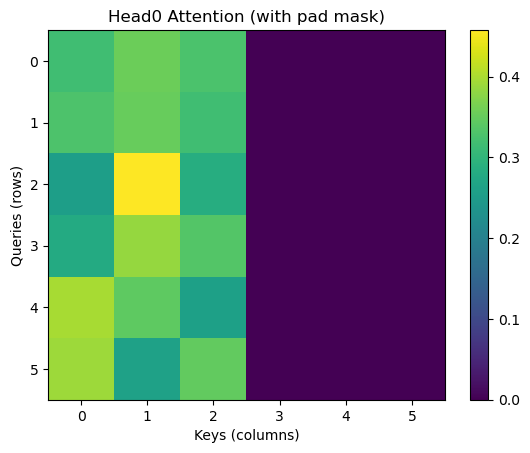

In [57]:
import matplotlib.pyplot as plt

attn_mod = nn.MultiheadAttention(embed_dim=16, num_heads=2, batch_first=True)
x = torch.randn(1, 6, 16)
pad = torch.tensor([[False, False, False, True, True, True]])  # last three positions PAD

_, w = attn_mod(x, x, x, key_padding_mask=pad, need_weights=True, average_attn_weights=False)  # [B,h,T,T]
w = w[0,0]  #  head0: [T,T]

print("[8] row sums (≈1):", w.sum(-1))
print("[8] masked cols sum (≈0):", w[:, 3:].sum())

plt.imshow(w.detach().numpy(), aspect='auto')     # visualize the attention weights
plt.colorbar(); plt.title("Head0 Attention (with pad mask)")
plt.xlabel("Keys (columns)"); plt.ylabel("Queries (rows)")
plt.show()